
## 🖼️ What is YOLOv5?

YOLO an acronym for 'You only look once', is an object detection algorithm that divides images into a grid system. Each cell in the grid is responsible for detecting objects within itself.

[Ultralytics' YOLOv5](https://ultralytics.com/yolov5) ("You Only Look Once") model family enables real-time object detection with convolutional neural networks. 

## What is Weights and Biases?

Weights and bias is platform for experiment tracking wchich is very helpful for debugging purpose and analyazing




# ☀️ Imports and Setup

Yolo expects our data to be in a certain format,That format is specified below

```
/parent_folder
    /dataset
         /images
         /labels
    /yolov5
```

* We thus will create a `/tmp` directory. <br>
* Download YOLOv5 repository and pip install the required dependencies. <br>
* Install the latest version of W&B and login with your wandb account. You can create your free W&B account [here](https://wandb.ai/site).

In [1]:
%cd ../
!mkdir tmp
%cd tmp


/kaggle
/kaggle/tmp


In [2]:
pwd

'/kaggle/tmp'

In [3]:
# Download YOLOv5
!git clone https://github.com/ultralytics/yolov5  # cloning the yolo repo
%cd yolov5
%pip install -qr requirements.txt  # install dependencies

%cd ../

Cloning into 'yolov5'...
remote: Enumerating objects: 10017, done.
remote: Total 10017 (delta 0), reused 0 (delta 0), pack-reused 10017
Receiving objects: 100% (10017/10017), 10.32 MiB | 31.00 MiB/s, done.
Resolving deltas: 100% (6950/6950), done.
/kaggle/tmp/yolov5
Note: you may need to restart the kernel to use updated packages.
/kaggle/tmp
Setup complete. Using torch 1.7.0 (Tesla P100-PCIE-16GB)


# Importing libraries

In [4]:

import os

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from shutil import copyfile
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split



# 🛠 Config

In [7]:
TRAIN_PATH = "../input/siim-covid19-resized-to-256px-jpg/train"
IMG_SIZE = 256
BATCH_SIZE = 16
EPOCHS = 10

# 🔨 Preparing the Dataset



In [8]:
df=pd.read_csv("../input/siim-covid19-detection/train_image_level.csv")

df['id'] = df.apply(lambda row: row.id.split('_')[0], axis=1)

df['image_level'] = df.apply(lambda row: row.label.split(' ')[0], axis=1)

df['path'] = df.apply(lambda row: TRAIN_PATH+row.id+'.jpg', axis=1)
df.head(5)

,id,boxes,label,StudyInstanceUID,path,image_level
0,000a312787f2,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,../input/siim-covid19-resized-to-256px-jpg/tra...,opacity
1,000c3a3f293f,NaN,none 1 0 0 1 1,ff0879eb20ed,../input/siim-covid19-resized-to-256px-jpg/tra...,none
2,0012ff7358bc,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,../input/siim-covid19-resized-to-256px-jpg/tra...,opacity
3,001398f4ff4f,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,../input/siim-covid19-resized-to-256px-jpg/tra...,opacity
4,001bd15d1891,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,../input/siim-covid19-resized-to-256px-jpg/tra...,opacity


In [9]:
# Load meta.csv file and making a training dataframe from that
meta_df = pd.read_csv('../input/siim-covid19-resized-to-256px-jpg/meta.csv')
train_meta_df = meta_df.loc[meta_df.split == 'train']
train_meta_df = train_meta_df.drop('split', axis=1)
train_meta_df.columns = ['id', 'dim0', 'dim1']

train_meta_df.head(2)

,id,dim0,dim1
1263,d8ba599611e5,2336,2836
1264,29b23a11d1e4,3488,4256


In [10]:
#Merging the train file from meta.csv to our original df
df = df.merge(train_meta_df, on='id',how="left")
df.head(2)

,id,boxes,label,StudyInstanceUID,path,image_level,dim0,dim1
0,000a312787f2,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,../input/siim-covid19-resized-to-256px-jpg/tra...,opacity,3488,4256
1,000c3a3f293f,NaN,none 1 0 0 1 1,ff0879eb20ed,../input/siim-covid19-resized-to-256px-jpg/tra...,none,2320,2832


## 🍘 Train-validation split

In [11]:
# Create train and validation split.
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df.image_level.values)

train_df.loc[:, 'split'] = 'train'
valid_df.loc[:, 'split'] = 'valid'

df = pd.concat([train_df, valid_df]).reset_index(drop=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [12]:
print(f'Size of dataset: {len(df)}, training images: {len(train_df)}. validation images: {len(valid_df)}')

Size of dataset: 6334, training images: 5067. validation images: 1267


## 🍚 Prepare Required Folder Structure

The required folder structure for the dataset directory is: 

```
/parent_folder
    /dataset
         /images
             /train
             /val
         /labels
             /train
             /val
    /yolov5
```

In [13]:
os.makedirs('tmp/covid/images/train', exist_ok=True)
os.makedirs('tmp/covid/images/valid', exist_ok=True)

os.makedirs('tmp/covid/labels/train', exist_ok=True)
os.makedirs('tmp/covid/labels/valid', exist_ok=True)

! ls tmp/covid/images

train  valid


In [15]:
# Moving the images to respective folders
for i in tqdm(range(len(df))):
    row = df.loc[i]
    if row.split == 'train':
        copyfile(f'../input/siim-covid19-resized-to-256px-jpg/train/{row.id}.jpg', f'tmp/covid/images/train/{row.id}.jpg')
    else:
        copyfile(f'../input/siim-covid19-resized-to-256px-jpg/train/{row.id}.jpg', f'tmp/covid/images/valid/{row.id}.jpg')

100%|██████████| 6334/6334 [00:39<00:00, 158.63it/s]


## 🍜 Create `.YAML` file

The `data.yaml`, is the dataset configuration file that contains the directory path of train and valid images which help the yolov5 algorithm to process the images


In [28]:
import yaml

data_yaml = dict(
    train = '/kaggle/tmp/tmp/covid/images/train',
    val = '/kaggle/tmp/tmp/covid/images/valid',
    nc = 2,
    names = ['none', 'opacity']
)


with open('/kaggle/tmp/yolov5/data/data.yaml', 'w') as outfile:
    yaml.dump(data_yaml, outfile, default_flow_style=True)
    
%cat yolov5/data/data.yaml

cat: yolov5/data/data.yaml: No such file or directory


## 🍮 Prepare Bounding Box Coordinated for YOLOv5

For every image with **bounding box(es)** a `.txt` file with the same name as the image will be created in the format shown below:

* One row per object. <br>
* Each row is class `x_center y_center width height format`. <br>
* Box coordinates must be in normalized xywh format (from 0 - 1). We can normalize by the boxes in pixels by dividing `x_center` and `width` by image width, and `y_center` and `height` by image height. <br>
* Class numbers are zero-indexed (start from 0). <br>

> 📍 Note: We don't have to remove the images without bounding boxes from the training or validation sets. 

In [19]:
#get_bbox  fuctions gives us the co-ordinates of the bounding boxes
def get_bbox(row):
    bboxes = []
    bbox = []
    for i, l in enumerate(row.label.split(' ')):
        if (i % 6 == 0) | (i % 6 == 1):
            continue
        bbox.append(float(l))
        if i % 6 == 5:
            bboxes.append(bbox)
            bbox = []  
            
    return bboxes

# Scale the bounding boxes according to the size of the resized image. 
def scale_bbox(row, bboxes):
    # Get scaling factor
    scale_x = IMG_SIZE/row.dim1
    scale_y = IMG_SIZE/row.dim0
    
    scaled_bboxes = []
    for bbox in bboxes:
        x = int(np.round(bbox[0]*scale_x, 4))
        y = int(np.round(bbox[1]*scale_y, 4))
        x1 = int(np.round(bbox[2]*(scale_x), 4))
        y1= int(np.round(bbox[3]*scale_y, 4))

        scaled_bboxes.append([x, y, x1, y1]) # xmin, ymin, xmax, ymax
        
    return scaled_bboxes

# Convert the bounding boxes in YOLO format.
def get_yolo_format_bbox(img_w, img_h, bboxes):
    yolo_boxes = []
    for bbox in bboxes:
        w = bbox[2] - bbox[0] # xmax - xmin
        h = bbox[3] - bbox[1] # ymax - ymin
        xc = bbox[0] + int(np.round(w/2)) # xmin + width/2
        yc = bbox[1] + int(np.round(h/2)) # ymin + height/2
        
        yolo_boxes.append([xc/img_w, yc/img_h, w/img_w, h/img_h]) # x_center y_center width height
    
    return yolo_boxes

In [20]:
# Prepare the txt files for bounding box
for i in tqdm(range(len(df))):
    row = df.loc[i]
    img_id = row.id
    split = row.split
    label = row.image_level
    
    if row.split=='train':
        file_name = f'tmp/covid/labels/train/{row.id}.txt'
    else:
        file_name = f'tmp/covid/labels/valid/{row.id}.txt'
        
    
    if label=='opacity':
        # Now we are going to use the above created functions to prepare the .txt file in yolo format
        bboxes = get_bbox(row)
        scale_bboxes = scale_bbox(row, bboxes)
        yolo_bboxes = get_yolo_format_bbox(IMG_SIZE, IMG_SIZE, scale_bboxes)
        
        with open(file_name, 'w') as f:
            for bbox in yolo_bboxes:
                bbox = [1]+bbox
                bbox = [str(i) for i in bbox]
                bbox = ' '.join(bbox)
                f.write(bbox)
                f.write('\n')

100%|██████████| 6334/6334 [00:02<00:00, 2346.88it/s]


# 🚅 Train with W&B



In [21]:
%cd yolov5

/kaggle/tmp/yolov5


### Parameters for training

```
--img {IMG_SIZE} \ # Input image size.
--batch {BATCH_SIZE} \ # Batch size
--epochs {EPOCHS} \ # Number of epochs
--data data.yaml \ # Configuration file
--weights yolov5s.pt \ # Model name
--save_period 1\ # Save model after interval
--project kaggle-siim-covid # W&B project name
```

In [22]:
# Weights and bias login for my account and for this experiment
%pip install -q wandb
import wandb
wandb.login()

Note: you may need to restart the kernel to use updated packages.


wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [25]:
pwd

'/kaggle/tmp/yolov5'

In [29]:
!python train.py --img {IMG_SIZE} \
                 --batch {BATCH_SIZE} \
                 --epochs {EPOCHS} \
                 --data data.yaml \
                 --weights yolov5s.pt \
                 --save-period 1\
                 --project kaggle-siim-covid

github: up to date with https://github.com/ultralytics/yolov5 ✅
2021-11-25 11:16:12.482675: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
wandb: Currently logged in as: yaswanth19 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
2021-11-25 11:16:17.351713: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-11-25 11:16:17.354093: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
wandb: Tracking run with wandb version 0.10.26
wandb: Syncing run dark-waterfall-3
wandb: ⭐️ View project at https://wandb.ai/yaswanth19/kaggle-siim-covid
wandb: 🚀 View run at https://wandb.ai/yaswanth19/kaggle-siim-covid/runs/3u2ji00n
wandb: Run data is saved locally in /kaggle/tmp/yolov5/wandb/run-202

In [33]:
TEST_PATH = '/kaggle/input/siim-covid19-resized-to-256px-jpg/test/' # absolute path

In [31]:
MODEL_PATH = 'kaggle-siim-covid/exp/weights/best.pt'

### Parameters for Inference

```
--weights {MODEL_PATH} \ # path to the best model.
--source {TEST_PATH} \ # absolute path to the test images.
--img {IMG_SIZE} \ # Size of image
--conf 0.281 \ # Confidence threshold (default is 0.25)
--iou-thres 0.5 \ # IOU threshold (default is 0.45)
--max-det 3 \ # Number of detections per image (default is 1000) 
--save-txt \ # Save predicted bounding box coordinates as txt files
--save-conf # Save the confidence of prediction for each bounding box
```

In [34]:
!python detect.py --source {TEST_PATH} \
                  --img {IMG_SIZE} \
                  --conf 0.281 \
                  --iou-thres 0.5 \
                  --max-det 3 \
                  --save-txt \
                  --save-conf

In [54]:
pwd

'/kaggle/tmp/yolov5'

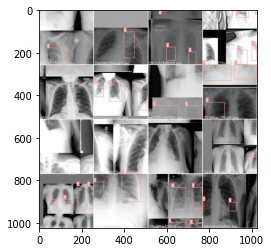

In [55]:
#plotting our predictions
plt.imshow(plt.imread('/kaggle/tmp/yolov5/kaggle-siim-covid/exp/train_batch0.jpg'))

### The predictions are stored in weights and bias for this experiment(.txt files),which you can download it from there